In [205]:
# Loading libraries

import os

import pandas as pd
import numpy as np

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords.words('English')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, confusion_matrix, f1_score

In [206]:
# Loading data
path = os.getcwd()
folder = path + "/cleaned_df/"

train = []
test = []
val = []

for file in sorted(os.listdir(folder)):
    fname = file.split('.')[0]
    df = pd.read_csv(folder + file)
    if re.search("train", fname):
        train.append(df)
    if re.search("test", fname):
        test.append(df)
    if re.search("val", fname):
        val.append(df)

df_names = sorted(list(set(file.split('_')[0] for file in os.listdir(folder))))

In [207]:
# Creating a dictionary to facilitate access to the dataframes

train_named = dict(zip(df_names, train))
test_named = dict(zip(df_names, test))
val_named = dict(zip(df_names, val))

In [208]:
# Looking at the abortion training dataset

pd.set_option('display.max_colwidth', None)
train_named['abortion'].head(10)

,tweet,tag
0,remind ourselves that love means willing give until hurts mother teresa,1
1,and most islanders have different definitions timely access irony peipoli peivotes,0
2,life precious are babies mothers fathers please support the sanctity human life think,1
3,too many people are taking this seriously,0
4,dude won freeshirt from never win anything lol abort,0
5,like yall can try and push your views anyway but will remain,0
6,just because legal doesnt make god honoring samesexmarriage themovie audacitymovie,0
7,maybe thats what wants,0
8,being mothers womb isnt safe guess neither are churches specifically black ones whoisburningblackchurches,1
9,nothing with its not choice nor yours dictate what another woman chooses feminism,2


In [209]:
# Creating a subset of relevant stances to predict

subset_names = ['abortion', 'atheism', 'climate', 'feminist']

/Users/giovannachaves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


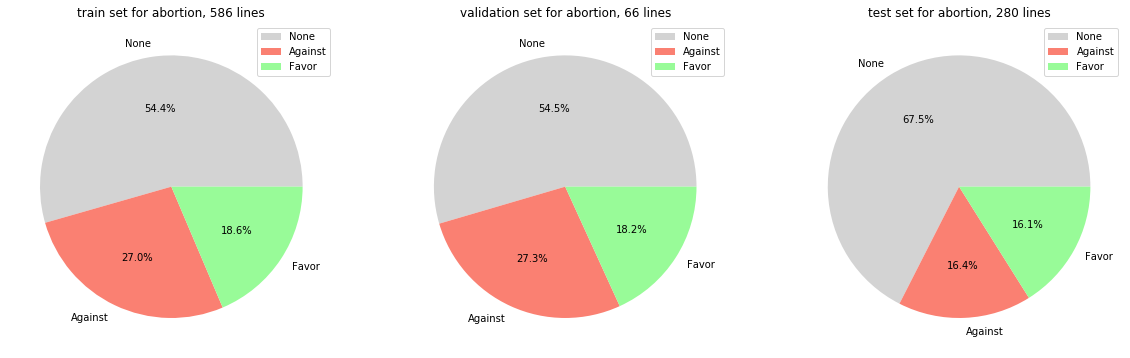

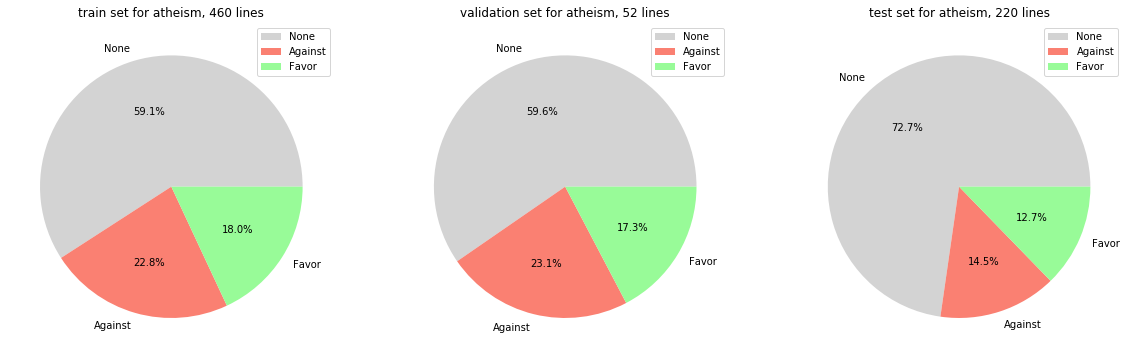

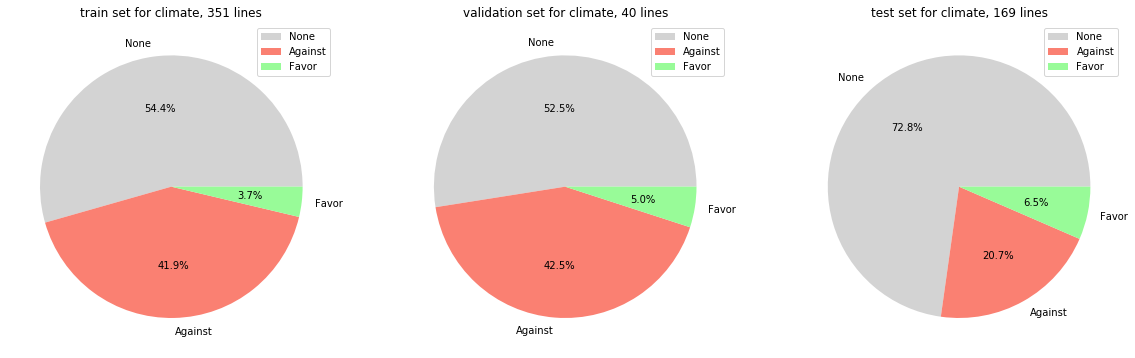

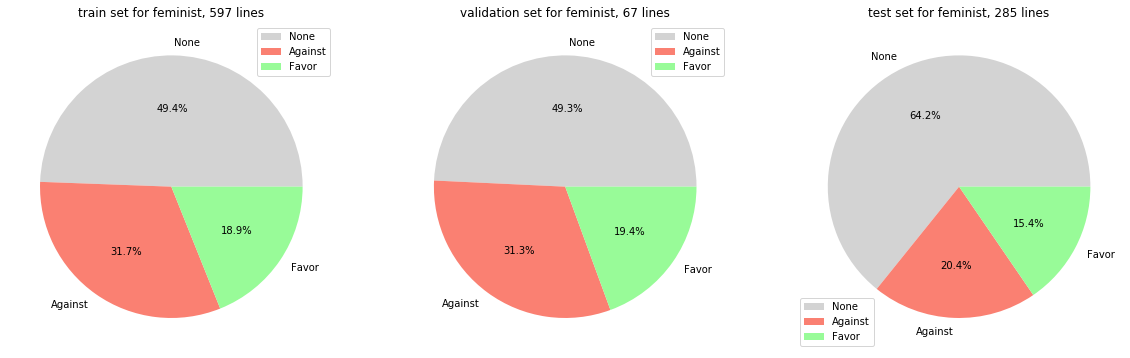

In [210]:
# Visualizing the distribution of support and opposition to topics

for subset in subset_names:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
    for i, (df, name) in enumerate(zip([train_named[subset], val_named[subset], test_named[subset]], ['train', 'validation','test'])):
        y = df.tag.value_counts().values / len(df) * 100
        ax[i].pie(y, colors=['lightgray', 'salmon', 'palegreen'], autopct='%1.1f%%', labels=['None', 'Against', 'Favor'])
        ax[i].legend()
        ax[i].set_title(f'{name} set for {subset}, {len(df)} lines')
    fig.show()
    

In [255]:
# Tokenizing and removing stopwords

tokens_favor = []
tokens_against = []

for subset in subset_names:
    
    pro_token = [word_tokenize(tweets) for tweets in train_named[subset].loc[train_named[subset].loc[:, 'tag'] == 2, 'tweet'].values]
    anti_token = [word_tokenize(tweets) for tweets in train_named[subset].loc[train_named[subset].loc[:, 'tag'] == 1, 'tweet'].values]
    
    stop_words = set(stopwords.words('English'))
    
    pro_tok = []
    for tweet in pro_token:
        tok = [w for w in tweet if not w in stop_words]
        pro_tok.append(tok)
    
    tokens_favor.append(pro_tok)
    
    anti_tok = []
    for tweet in anti_token:
        tok = [w for w in tweet if not w in stop_words]
        anti_tok.append(tok)
    
    tokens_against.append(anti_tok)


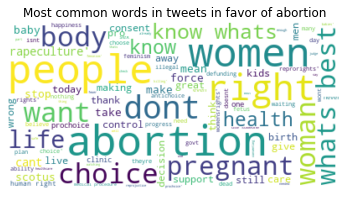

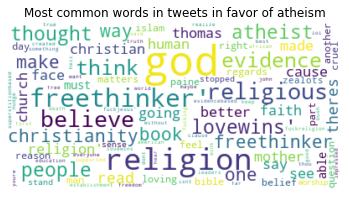

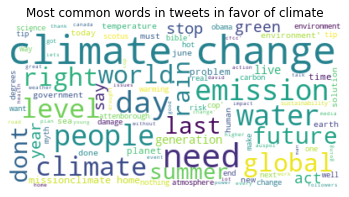

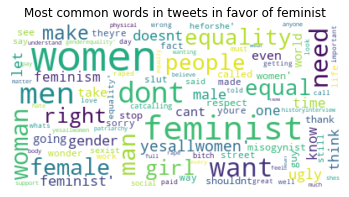

In [259]:
# Visualizing the most common words in favor of the topics

for i in range(len(tokens_favor)):
    texts = [' '.join(tokens) for tokens in tokens_favor[i]]
    favor_wordcloud = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(texts))
    
    plt.figure()
    plt.title(f'Most common words in tweets in favor of {subset_names[i]}')
    plt.imshow(favor_wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

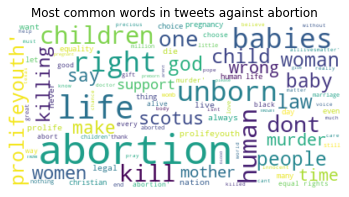

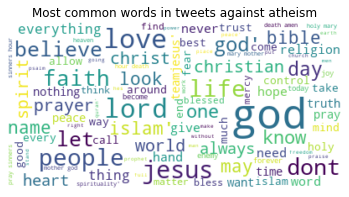

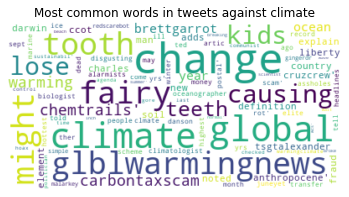

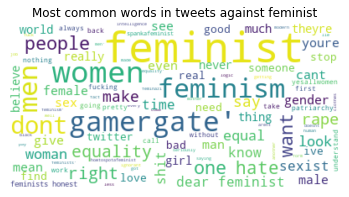

In [260]:
# Visualizing the most common words against the topics

for i in range(len(tokens_against)):

    texts = [' '.join(tokens) for tokens in tokens_against[i]]
    against_wordcloud = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(texts))
    
    plt.figure()
    plt.title(f'Most common words in tweets against {subset_names[i]}')
    plt.imshow(against_wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [323]:
# Defining the metrics we want to use

def get_metrics(y_trues, y_preds, average, verbose=True):
    
    recall = recall_score(y_trues, y_preds, average = average) * 100
    precision = precision_score(y_trues, y_preds, average = average) * 100
    accuracy = accuracy_score(y_trues, y_preds) * 100
    f1 = f1_score(y_trues, y_preds, average = average) * 100
    
    if verbose:
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'Accuracy: {accuracy:.2f}')
        print(f'F1: {f1:.2f}')
        
    return recall, precision, accuracy, f1 

In [324]:
# Scores obtained by a random classifier 

precisions, recalls, accuracies, f1s = [], [], [], []

avg = 'weighted'

for i in range(1000):
    trues = np.random.randint(0, 3, 1000)
    preds = np.random.randint(0, 3, 1000)
    
    precision, recall, accuracy, f1 = get_metrics(trues, preds, average = 'weighted', verbose=False)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1s.append(f1)

print('Final metrics')
print(f'Precision: {np.mean(precisions):.2f} ({np.std(precisions):.2f})')
print(f'Recall: {np.mean(recalls):.2f} ({np.std(recalls):.2f})')
print(f'Accuracy: {np.mean(accuracies):.2f} ({np.std(accuracies):.2f})')
print(f'F1: {np.mean(f1s):.2f} ({np.std(f1s):.2f})')

Final metrics
Precision: 33.28 (1.48)
Recall: 33.35 (1.48)
Accuracy: 33.28 (1.48)
F1: 33.28 (1.48)


In [325]:
# ROC AUC score obtained by a random classifier 

roc_aucs = []

for i in range(1000):
    trues = np.random.randint(0, 3, 1000)
    pred_probas = []
    
    for i in range(1000):
        preds = np.random.uniform(0, 1, 3)
        summ = sum(preds)
        preds_norm = preds/summ

        pred_probas.append(preds_norm)
    
    roc_auc = roc_auc_score(trues, pred_probas, average = 'weighted', multi_class = 'ovr')
    roc_aucs.append(roc_auc)

print(f'ROC AUC: {np.mean(roc_aucs):.2f} ({np.std(roc_aucs):.2f})')

ROC AUC: 0.50 (0.01)


In [326]:
def get_outputs(texts, dictionary): 
    
    # count how many words in the tweet belong to each dictionary 
    
    outputs = []
    for text in texts:
        founds = re.findall(r'\b(?:{})\b'.format('|'.join(dictionary)), text)
        n = len(founds)
        outputs.append(n)
        
    return outputs

def get_final_outputs(positive_outputs, negative_outputs): 
    
    # predict in favor, against or neutral based on count
    
    assert len(positive_outputs) == len(negative_outputs), 'ValueError: both lists should have the same size'
    outputs = []
    for pos, neg in zip(positive_outputs, negative_outputs):
        if pos > neg:
            outputs.append(2)
        elif pos < neg:
            outputs.append(1)
        else:
            outputs.append(0)
    
    return outputs

def get_baseline_metrics(my_texts, trues, good_dictionary, bad_dictionary, verbose=True):
    
    # return the metrics for the baseline model
    
    positive_outputs = get_outputs(my_texts, good_dictionary)
    negative_outputs = get_outputs(my_texts, bad_dictionary)
    
    outputs = np.array(get_final_outputs(positive_outputs, negative_outputs))
    precision, recall, accuracy, f1 = get_metrics(trues, outputs, average = 'weighted', verbose=True)
    
    return outputs

In [328]:
# Creating the dictionaries

frequency = 0.5
min_count = 5

favor_texts = train_named['abortion'].loc[train_named['abortion'].loc[:, 'tag'] == 2, 'tweet'].values
against_texts = train_named['abortion'].loc[train_named['abortion'].loc[:, 'tag'] == 1, 'tweet'].values

vectorizer = CountVectorizer(min_df=min_count)
vectorizer.fit([' '.join(tokens) for tokens in tokens_favor[0]] + 
               [' '.join(tokens) for tokens in tokens_against[0]])

X_pos = vectorizer.transform([' '.join(tokens) for tokens in tokens_favor[0]])
X_neg = vectorizer.transform([' '.join(tokens) for tokens in tokens_against[0]])

X = np.concatenate((np.array(X_pos.sum(axis=0))[0, :].reshape(-1, 1),
                    np.array(X_neg.sum(axis=0))[0, :].reshape(-1, 1)), axis=1)

X = X / X.sum(axis=1).reshape(-1, 1)

proba_dict = sorted({word: proba for word, proba in zip(vectorizer.get_feature_names_out(),
                                                    X[:, 0])}.items(), key=lambda x: x[1], reverse=True)

positive_dict = [x[0] for x in proba_dict if x[1] > frequency]
negative_dict = [x[0] for x in proba_dict if x[1] < frequency][::-1]

In [329]:
print(f'The scores for abortion are...')
baseline_score = get_baseline_metrics(train_named['abortion'].tweet, train_named['abortion'].tag,
                                       positive_dict, negative_dict, verbose = True)

The scores for abortion are...
Precision: 64.64
Recall: 65.87
Accuracy: 65.87
F1: 62.78


In [338]:
# Creating the dictionaries

frequency = [0.5, 0.5, 0.5, 0.5] #try (0.75, 5) for climate and feminist
min_count = [5, 5, 10, 10]

positive_dicts = []
negative_dicts = []

for subset, i in zip(subset_names, range(len(tokens_favor))):
    favor_texts = train_named[subset].loc[train_named[subset].loc[:, 'tag'] == 2, 'tweet'].values
    against_texts = train_named[subset].loc[train_named[subset].loc[:, 'tag'] == 1, 'tweet'].values
    
    vectorizer = CountVectorizer(min_df=min_count)
    vectorizer.fit([' '.join(tokens) for tokens in tokens_favor[i]] + 
               [' '.join(tokens) for tokens in tokens_against[i]])
    
    X_pos = vectorizer.transform([' '.join(tokens) for tokens in tokens_favor[0]])
    X_neg = vectorizer.transform([' '.join(tokens) for tokens in tokens_against[0]])
    
    X = np.concatenate((np.array(X_pos.sum(axis=0))[0, :].reshape(-1, 1),
                    np.array(X_neg.sum(axis=0))[0, :].reshape(-1, 1)), axis=1)
    X = X / X.sum(axis=1).reshape(-1, 1)
    
    proba_dict = sorted({word: proba for word, proba in zip(vectorizer.get_feature_names_out(),
                                                    X[:, 0])}.items(), key=lambda x: x[1], reverse=True)
    
    positive_dictionary = [x[0] for x in proba_dict if x[1] > frequency[]]
    positive_dicts.append(positive_dictionary)
    
    negative_dictionary = [x[0] for x in proba_dict if x[1] < frequency[i]][::-1]
    negative_dicts.append(negative_dictionary)

/Users/giovannachaves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [347]:
baseline_scores = []
for subset, i in zip(subset_names, range(len(tokens_favor))):
    print(f'The scores for {subset} are...')
    baseline_score = get_baseline_metrics(train_named[subset].tweet, train_named[subset].tag,
                                       positive_dicts[i], negative_dicts[i], verbose = True)
    
    baseline_scores.append(baseline_score)

The scores for abortion are...
Precision: 61.37
Recall: 62.97
Accuracy: 62.97
F1: 61.03
The scores for atheism are...
Precision: 52.44
Recall: 52.17
Accuracy: 52.17
F1: 50.48
The scores for climate are...
Precision: 63.75
Recall: 44.16
Accuracy: 44.16
F1: 31.58
The scores for feminist are...
Precision: 46.87
Recall: 45.06
Accuracy: 45.06
F1: 44.84


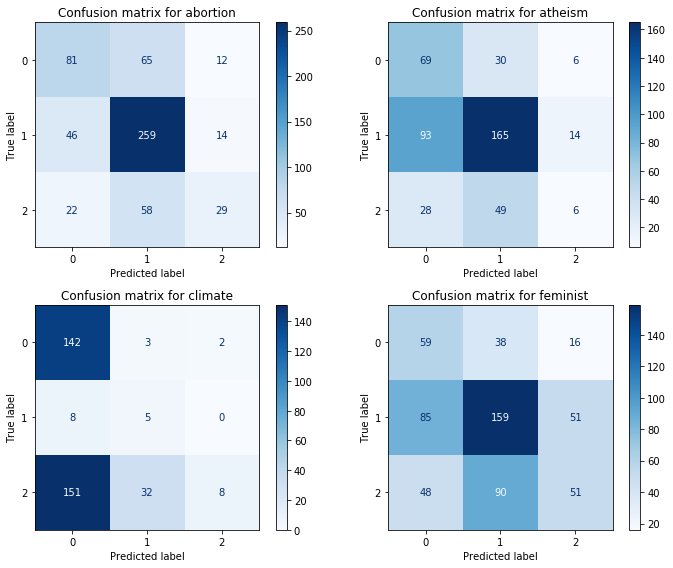

In [376]:
# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Loop through the subsets and scores
for i, subset in enumerate(subset_names):
    row = i // 2
    col = i % 2

    # Calculate the confusion matrix and create a ConfusionMatrixDisplay object
    cm = confusion_matrix(train_named[subset].tag, baseline_scores[i], labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(cm)

    # Plot the confusion matrix in the appropriate subplot
    disp.plot(cmap="Blues", ax=axs[row, col])
    axs[row, col].set_title(f'Confusion matrix for {subset}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()